In [1]:
import matplotlib.pyplot as plt
import glob
import sys
import os
PATH = os.getcwd()
for dir_idx, dir_name in enumerate(PATH.split('/')):
    dir_path = '/'.join(PATH.split('/')[:(dir_idx+1)])
    file_list = [os.path.basename(sub_dir) for sub_dir in glob.glob(f"{dir_path}/.*")]
    if '.trc_package' in file_list:
        PATH = dir_path
        break
if not PATH in sys.path:
    sys.path.append(PATH)
from utils.vectorize import SingleEnvWrapper
from utils.logger import Logger
from utils import register
from utils.env import Env

from agent import Agent

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import argparse
import random
import wandb
import torch
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

/home/tbot/anaconda3/envs/srl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = Env("Turtlebot-medium-v0", 0, 1000, "easy")

/home/tbot/anaconda3/envs/srl/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
actions = [[0, 0],
           [0.1, 0.0], [0.2, 0.2], [0.2, 0.2], [0.5, 0.5], [0.0, 0.0], [0.4,-0.4],
           [0.4,-0.4], [0.1, 0.1], [0.6, 0.6], [0.6, 0.6], [0.0,0.4], [0.1,0.4],
           [0.6,0], [0.4, 0.4], [0, 0], [0.3, 0.6], [0.1, 0], [0.6, 0.0], [0, -0.5]]

In [4]:
def mae(y_real, y_pred):
    return (1/len(y_real))*np.sum(np.abs(y_real-y_pred))

def obj_fun(params):
    real_vels = []
    real_ang_vels = []
    vels = []
    ang_vels = []
    
    kp = params['kp']
    ki = params['ki']
    kd = params['kd']
    ap = params['ap']
    ai = params['ai']
    ad = params['ad']

    env.set_pid(kp, ki, kd, ap, ai, ad)
    state = env.reset()
    for i in range(len(actions)):
        real_vel, real_ang_vel, _, _ = env.step(actions[i])
        real_vels.append(np.round(real_vel, 2))
        real_ang_vels.append(np.round(real_ang_vel, 2))
        for j in range(int(1.0/(env.time_step*env.control_freq))):
            vels.append(actions[i][0])
            ang_vels.append(actions[i][1])
    real_vels = np.reshape(np.array(real_vels), -1)
    vels = np.reshape(np.array(vels), -1)
    ang_vels = np.reshape(np.array(ang_vels), -1)
    real_ang_vels = np.reshape(np.array(real_ang_vels), -1)
    
    mae_k = mae(real_vels, vels)
    mae_a = mae(real_ang_vels, ang_vels)
    
    return {'loss': (2 * mae_k + mae_a)/3, 'status': STATUS_OK}

In [5]:
space = {
    'kp': hp.uniform('kp', 0, 1000),
    'ki': hp.uniform('ki', 0, 100),
    'kd': hp.uniform('kd', 0, 100),
    'ap': hp.uniform('ap', 0, 1000),
    'ai': hp.uniform('ai', 0, 100),
    'ad': hp.uniform('ad', 0, 100)
}

best = fmin(
    fn=obj_fun,
    space=space,
    algo=tpe.suggest, max_evals=1000)
print(best)

100%|██████████| 1000/1000 [02:36<00:00,  6.39trial/s, best loss: 0.13966]           
{'ad': 52.260588001102, 'ai': 12.061173091354043, 'ap': 775.5777697892646, 'kd': 23.094126976729825, 'ki': 0.04634564685837501, 'kp': 278.08566157022295}


In [6]:
env = Env("Turtlebot-medium-v0", 0, 1000, "easy")
real_vels = []
real_ang_vels = []
vels = []
ang_vels = []

kp = best['kp']
ki = best['ki']
kd = best['kd']
ap = best['ap']
ai = best['ai']
ad = best['ad']
env.set_pid(kp, ki, kd, ap, ai, ad)

state = env.reset()
for i in range(len(actions)):
    real_vel, real_ang_vel, _, _ = env.step(actions[i])
    real_vels.append(np.round(real_vel, 2))
    real_ang_vels.append(np.round(real_ang_vel, 2))
    for j in range(int(1.0/(env.time_step*env.control_freq))):
        vels.append(actions[i][0])
        ang_vels.append(actions[i][1])
real_vels = np.reshape(np.array(real_vels), -1)
vels = np.reshape(np.array(vels), -1)
ang_vels = np.reshape(np.array(ang_vels), -1)
real_ang_vels = np.reshape(np.array(real_ang_vels), -1)

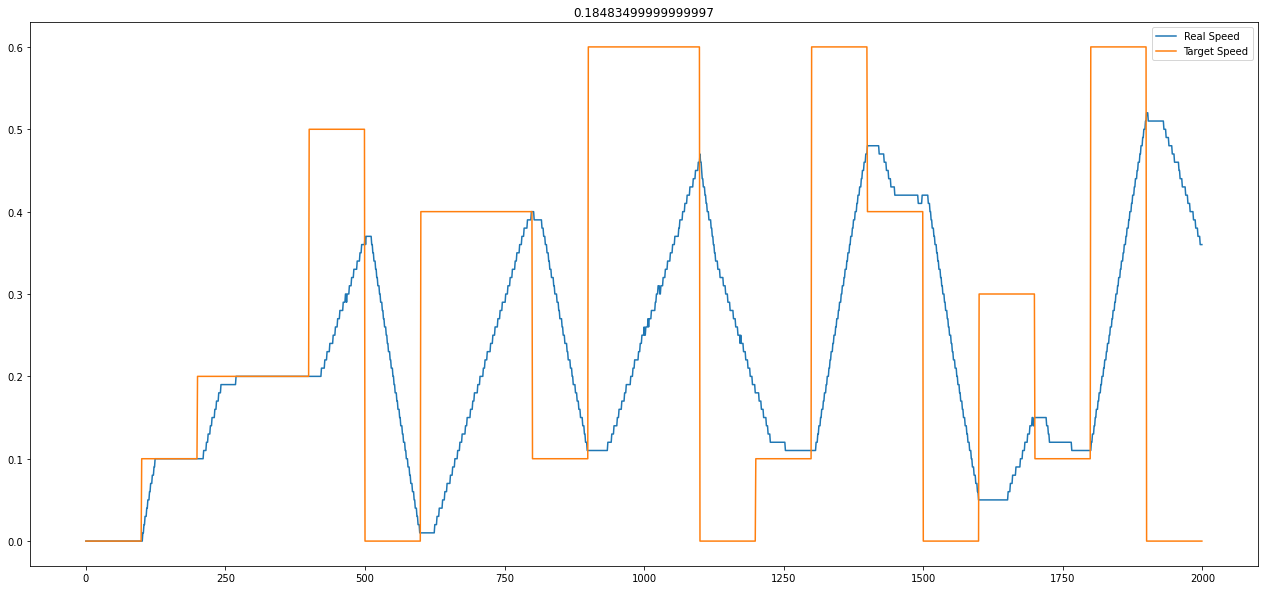

In [7]:
plt.figure(figsize=(22,10))
plt.title(mae(real_vels, vels))
plt.plot(real_vels)
plt.plot(vels)
plt.legend(["Real Speed", "Target Speed"])
plt.show()

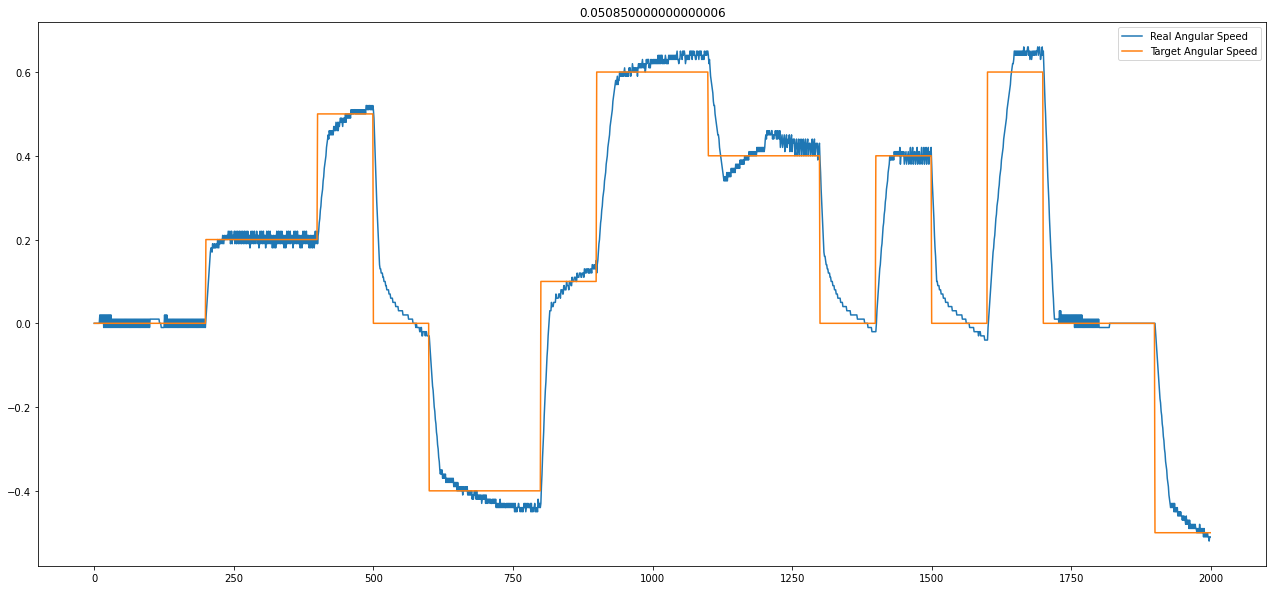

In [8]:
plt.figure(figsize=(22,10))
plt.title(mae(real_ang_vels, ang_vels))
plt.plot(real_ang_vels)
plt.plot(ang_vels)
plt.legend(["Real Angular Speed", "Target Angular Speed"])
plt.show()

In [9]:
env.control_freq

5